In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter 
from matplotlib.ticker import EngFormatter
import math
%matplotlib inline


def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

# accepts table (dataframe) of loaded statistics, does pivot on the atributes, add them as separate columns and
# runnattr (row) as a column for easy legend plotting
def addItervarsCol(loaded_csv):
    
    #get only three columns (run, attribute name, attribute value)
    itervars_df = loaded_csv.loc[loaded_csv.type=='itervar', ['run', 'attrname', 'attrvalue']]
    #pivot the table around attrname
    itervarsprivot_df = itervars_df.pivot(index = 'run', columns = 'attrname', values = 'attrvalue')
    #merge it with the original table i.e. add the new columns
    loaded_csv_merged = loaded_csv.merge(itervarsprivot_df, left_on='run', right_index=True, how='outer')
    
    # concat all parameters into one and add it as iterationvars column
    itervarscol_df = loaded_csv.loc[(loaded_csv.type=='runattr') & (loaded_csv.attrname.astype(str)=='iterationvars'), ['run', 'attrvalue']]
    itervarscol_df = itervarscol_df.rename(columns={'attrvalue': 'iterationvars'})
    
    #add iterationvars column to the final table
    loaded_csv3 = loaded_csv_merged.merge(itervarscol_df, left_on='run', right_on='run', how='outer')
    
    return loaded_csv3


def resampleVecvalue(loaded_csv, key="10ms"):
    loaded_csv.loc[(loaded_csv.type == "vector"),('resampled')] = loaded_csv.loc[(loaded_csv.type == "vector"),('vectime', 'vecvalue')].apply(lambda x:  pd.DataFrame(pd.Series(x.vecvalue, index = (pd.to_timedelta(x.vectime, unit='s'))).resample(key=key).sum()*8), axis= 1)
    return loaded_csv


def isnan(x):
    if isinstance(x, (int, float, complex)) and math.isnan(x):
        return True
    
def trimTimeDeltaSeries(series, after=pd.Timedelta.max, before=pd.Timedelta.min):
    return series[(series.index >= before) & (series.index <= after)]



In [3]:
# load csv

file_to_load = 'results/udpEcn/Hex_UdpEcnIntAlpha.csv'
loaded_csv = pd.read_csv(file_to_load, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray})

loaded_csv = addItervarsCol(loaded_csv)
loaded_csv.head(10)

,run,type,module,name,attrname,attrvalue,value,vectime,vecvalue,alpha,cross,interval,queueCap,iterationvars
0,HexSingleConnUdpRedUdpCrossIntervalAlpha-101-2...,runattr,NaN,NaN,configname,HexSingleConnUdpRedUdpCrossIntervalAlpha,NaN,None,None,0.005,"""Off""",0.05,24,"$queueCap=24, $cross=""Off"", $0=default, $1=def..."
1,HexSingleConnUdpRedUdpCrossIntervalAlpha-101-2...,runattr,NaN,NaN,datetime,20190227-17:45:40,NaN,None,None,0.005,"""Off""",0.05,24,"$queueCap=24, $cross=""Off"", $0=default, $1=def..."
2,HexSingleConnUdpRedUdpCrossIntervalAlpha-101-2...,runattr,NaN,NaN,experiment,HexSingleConnUdpRedUdpCrossIntervalAlpha,NaN,None,None,0.005,"""Off""",0.05,24,"$queueCap=24, $cross=""Off"", $0=default, $1=def..."
3,HexSingleConnUdpRedUdpCrossIntervalAlpha-101-2...,runattr,NaN,NaN,inifile,omnetpp.ini,NaN,None,None,0.005,"""Off""",0.05,24,"$queueCap=24, $cross=""Off"", $0=default, $1=def..."
4,HexSingleConnUdpRedUdpCrossIntervalAlpha-101-2...,runattr,NaN,NaN,iterationvars,"$queueCap=24, $cross=""Off"", $0=default, $1=def...",NaN,None,None,0.005,"""Off""",0.05,24,"$queueCap=24, $cross=""Off"", $0=default, $1=def..."
5,HexSingleConnUdpRedUdpCrossIntervalAlpha-101-2...,runattr,NaN,NaN,iterationvarsf,"queueCap=24,cross=Off,default,default,interval...",NaN,None,None,0.005,"""Off""",0.05,24,"$queueCap=24, $cross=""Off"", $0=default, $1=def..."
6,HexSingleConnUdpRedUdpCrossIntervalAlpha-101-2...,runattr,NaN,NaN,measurement,"$queueCap=24, $cross=""Off"", $0=default, $1=def...",NaN,None,None,0.005,"""Off""",0.05,24,"$queueCap=24, $cross=""Off"", $0=default, $1=def..."
7,HexSingleConnUdpRedUdpCrossIntervalAlpha-101-2...,runattr,NaN,NaN,network,Hexagon,NaN,None,None,0.005,"""Off""",0.05,24,"$queueCap=24, $cross=""Off"", $0=default, $1=def..."
8,HexSingleConnUdpRedUdpCrossIntervalAlpha-101-2...,runattr,NaN,NaN,processid,29359,NaN,None,None,0.005,"""Off""",0.05,24,"$queueCap=24, $cross=""Off"", $0=default, $1=def..."
9,HexSingleConnUdpRedUdpCrossIntervalAlpha-101-2...,runattr,NaN,NaN,repetition,0,NaN,None,None,0.005,"""Off""",0.05,24,"$queueCap=24, $cross=""Off"", $0=default, $1=def..."


In [14]:
#eliminate multiple rows for the same run X module X name (avoids getting 'duplicates' error on pivot later on)

# pd.set_option('max_colwidth', 80)
# save column order
col_order= loaded_csv.columns.tolist()
#create dictionary of reduce functions (need to list all columns)           
agg_dict = {"type": "first","attrname": "first", "attrvalue" : "first","value": "first","vectime": lambda x: list(np.hstack(x)), "vecvalue": lambda x: list(np.hstack(x)), "cross": "first","alpha": "first", "interval": "first","queueCap": "first","iterationvars": "first"}
#get copy of vectors
df_slice = loaded_csv[(loaded_csv.type=="vector")]

loaded_csv = df_slice.groupby(['run', 'module', 'name'], as_index = False).agg(agg_dict) 
loaded_csv = loaded_csv[col_order]
loaded_csv.head(25)

,run,type,module,name,attrname,attrvalue,value,vectime,vecvalue,alpha,cross,interval,queueCap,iterationvars
0,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,vector,Hexagon.client499.app[0],rcvdPk:vector(packetBytes),NaN,None,NaN,"[20.0206672, 20.02079024, 20.02091328, 20.0210...","[1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....",0.030,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv..."
1,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,vector,Hexagon.routerCore1.dmpr,congLevel. 192.168.4.0_eth[1]:vector,NaN,None,NaN,"[20.02585152, 20.02622064, 20.02646672, 20.027...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.0591, 0.0873...",0.030,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv..."
2,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,vector,Hexagon.routerCore1.dmpr,congLevel. 192.168.4.0_eth[2]:vector,NaN,None,NaN,"[20.02597456, 20.0260976, 20.02634368, 20.0265...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.030,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv..."
3,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,vector,Hexagon.routerCore1.dmpr,fwdCongLevel. 192.168.4.0_eth[1]:vector,NaN,None,NaN,"[20.0062672, 20.00639024, 20.00663632, 20.0068...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.030,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv..."
4,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,vector,Hexagon.routerCore1.dmpr,fwdCongLevel. 192.168.4.0_eth[2]:vector,NaN,None,NaN,"[20.00651328, 20.00675936, 20.00700544, 20.008...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.030,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv..."
5,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,vector,Hexagon.routerCore1.dmpr,inUseCongLevel. 192.168.4.0_eth[1]:vector,NaN,None,NaN,"[20.00639024, 20.01649416, 20.02699416, 20.037...","[0.0, 0.0, 0.0, 0.11470719, 0.26257587310507, ...",0.030,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv..."
6,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,vector,Hexagon.routerCore1.dmpr,inUseCongLevel. 192.168.4.0_eth[2]:vector,NaN,None,NaN,"[20.00639024, 20.01649416, 20.02699416, 20.037...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.030,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv..."
7,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,vector,Hexagon.routerCore1.eth[1].queue.red,packetDropCongestion:vector(packetBytes),NaN,None,NaN,"[21.54799416, 22.56799416, 23.60599416, 24.654...","[1504.0, 1504.0, 1504.0, 1504.0, 1504.0, 1504....",0.030,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv..."
8,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,vector,Hexagon.routerCore1.eth[2].queue.red,packetDropCongestion:vector(packetBytes),NaN,None,NaN,"[20.38024416, 20.38174416, 20.38399416, 20.387...","[1504.0, 1504.0, 1504.0, 1504.0, 1504.0, 1504....",0.030,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv..."
9,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,vector,Hexagon.routerCore2.eth[2].queue.red,packetDropCongestion:vector(packetBytes),NaN,None,NaN,"[20.23744416, 20.23984416, 20.24224416, 20.247...","[1504.0, 1504.0, 1504.0, 1504.0, 1504.0, 1504....",0.030,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv..."


In [26]:

# name which columns you want to include (usually all the variables you iterates over)
new_df = loaded_csv[['run', 'queueCap', 'cross', 'alpha', 'interval', 'iterationvars']].drop_duplicates('run').set_index(keys='run')
# print(new_df)
# loaded_csv.loc[:, [0,2,3,7] + list(range(8,loaded_csv.shape[1]))]

vectors = loaded_csv.loc[loaded_csv.type=="vector"]
vectors["module_name"] = vectors["module"].map(str) + "." +  vectors["name"]
vectors = vectors.iloc[:, [0,2,3,7] + list(range(8,vectors.shape[1]))]
# vectors["time_series"] = pd.Series(vectors["vecvalue"], index = pd.to_timedelta(vectors["vectime"],  unit='s'))

# a = vectors.iloc[0, 3]
# b = vectors.iloc[0, 4]
# # print(a)
# # print(b)
# pd.Series(b, index = pd.to_timedelta(a,  unit='s'))
# pd.Series(x["vecvalue"], index = pd.to_timedelta(x["vectime"],  unit='s'))
vectors["ser"] = vectors.apply(lambda x: pd.DataFrame(pd.Series(x["vecvalue"], index = pd.to_timedelta(x["vectime"],  unit='s'))), axis=1) 
# vectors
# vectors.assign(meh=lambda x: pd.Series(x["vecvalue"].tolist(), index = pd.to_timedelta(x["vectime"].tolist(),  unit='s')) )
vectors


,run,module,name,vectime,vecvalue,alpha,cross,interval,queueCap,iterationvars,module_name,ser
0,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,Hexagon.client499.app[0],rcvdPk:vector(packetBytes),"[20.0206672, 20.02079024, 20.02091328, 20.0210...","[1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....",0.0300,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv...",Hexagon.client499.app[0].rcvdPk:vector(packetB...,0 00:00:20.020667 1472....
1,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,Hexagon.routerCore1.dmpr,congLevel. 192.168.4.0_eth[1]:vector,"[20.02585152, 20.02622064, 20.02646672, 20.027...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.0591, 0.0873...",0.0300,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv...",Hexagon.routerCore1.dmpr.congLevel. 192.168.4....,0 00:00:20.025851 0.0...
2,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,Hexagon.routerCore1.dmpr,congLevel. 192.168.4.0_eth[2]:vector,"[20.02597456, 20.0260976, 20.02634368, 20.0265...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0300,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv...",Hexagon.routerCore1.dmpr.congLevel. 192.168.4....,0 00:00:20.025974 0.0...
3,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,Hexagon.routerCore1.dmpr,fwdCongLevel. 192.168.4.0_eth[1]:vector,"[20.0062672, 20.00639024, 20.00663632, 20.0068...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0300,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv...",Hexagon.routerCore1.dmpr.fwdCongLevel. 192.168...,0 00:00:20.006267 0.0 00:0...
4,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,Hexagon.routerCore1.dmpr,fwdCongLevel. 192.168.4.0_eth[2]:vector,"[20.00651328, 20.00675936, 20.00700544, 20.008...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0300,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv...",Hexagon.routerCore1.dmpr.fwdCongLevel. 192.168...,0 00:00:20.006513 0.0 00:0...
5,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,Hexagon.routerCore1.dmpr,inUseCongLevel. 192.168.4.0_eth[1]:vector,"[20.00639024, 20.01649416, 20.02699416, 20.037...","[0.0, 0.0, 0.0, 0.11470719, 0.26257587310507, ...",0.0300,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv...",Hexagon.routerCore1.dmpr.inUseCongLevel. 192.1...,0 00:00:20.006390 0.0...
6,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,Hexagon.routerCore1.dmpr,inUseCongLevel. 192.168.4.0_eth[2]:vector,"[20.00639024, 20.01649416, 20.02699416, 20.037...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0300,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv...",Hexagon.routerCore1.dmpr.inUseCongLevel. 192.1...,0 00:00:20.006390 0.0...
7,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,Hexagon.routerCore1.eth[1].queue.red,packetDropCongestion:vector(packetBytes),"[21.54799416, 22.56799416, 23.60599416, 24.654...","[1504.0, 1504.0, 1504.0, 1504.0, 1504.0, 1504....",0.0300,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv...",Hexagon.routerCore1.eth[1].queue.red.packetDro...,0 00:00:21.547994 1504....
8,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,Hexagon.routerCore1.eth[2].queue.red,packetDropCongestion:vector(packetBytes),"[20.38024416, 20.38174416, 20.38399416, 20.387...","[1504.0, 1504.0, 1504.0, 1504.0, 1504.0, 1504....",0.0300,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv...",Hexagon.routerCore1.eth[2].queue.red.packetDro...,0 00:00:20.380244 1504....
9,HexSingleConnUdpRedUdpCrossIntervalAlpha-0-201...,Hexagon.routerCore2.eth[2].queue.red,packetDropCongestion:vector(packetBytes),"[20.23744416, 20.23984416, 20.24224416, 20.247...","[1504.0, 1504.0, 1504.0, 1504.0, 1504.0, 1504....",0.0300,"""On""",0.01,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv...",Hexagon.routerCore2.eth[2].queue.red.packetDro...,0 00:00:20.237444 1504....


In [27]:
res=vectors.pivot(index = 'run', columns = 'module_name', values = ['ser'])
res.columns = res.columns.droplevel()
res

module_name,Hexagon.client499.app[0].rcvdPk:vector(packetBytes),Hexagon.routerCore1.dmpr.congLevel. 192.168.4.0_eth[1]:vector,Hexagon.routerCore1.dmpr.congLevel. 192.168.4.0_eth[2]:vector,Hexagon.routerCore1.dmpr.fwdCongLevel. 192.168.4.0_eth[1]:vector,Hexagon.routerCore1.dmpr.fwdCongLevel. 192.168.4.0_eth[2]:vector,Hexagon.routerCore1.dmpr.inUseCongLevel. 192.168.4.0_eth[1]:vector,Hexagon.routerCore1.dmpr.inUseCongLevel. 192.168.4.0_eth[2]:vector,Hexagon.routerCore1.eth[1].queue.red.packetDropCongestion:vector(packetBytes),Hexagon.routerCore1.eth[2].queue.red.packetDropCongestion:vector(packetBytes),Hexagon.routerCore2.eth[2].queue.red.packetDropCongestion:vector(packetBytes),Hexagon.routerCore4.eth[1].encap.decapPk:vector(packetBytes),Hexagon.routerCore4.eth[2].encap.decapPk:vector(packetBytes)
run,,,,,,,,,,,,
HexSingleConnUdpRedUdpCrossIntervalAlpha-0-20190227-17:43:19-29340,0 00:00:20.020667 1472....,0 00:00:20.025851 0.0...,0 00:00:20.025974 0.0...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 0.0...,0 00:00:20.006390 0.0...,0 00:00:21.547994 1504....,0 00:00:20.380244 1504....,0 00:00:20.237444 1504....,0 00:00:00.097418 64....,0 00:00:00.112811 68....
HexSingleConnUdpRedUdpCrossIntervalAlpha-1-20190227-17:45:46-29340,0 00:00:20.019442 1472....,0 00:00:20.024996 ...,0 00:00:20.024627 ...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 ...,0 00:00:20.006390 ...,NaN,0 00:00:20.418494 1504....,0 00:00:20.094464 1504....,0 00:00:00.110316 68....,0 00:00:00.103700 68....
HexSingleConnUdpRedUdpCrossIntervalAlpha-10-20190227-17:43:19-29323,0 00:00:20.020667 1472....,0 00:00:20.025851 ...,0 00:00:20.025974 ...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 ...,0 00:00:20.006390 ...,NaN,0 00:00:20.913494 1504....,0 00:00:20.082464 1504....,0 00:00:00.100555 68....,0 00:00:00.110343 64....
HexSingleConnUdpRedUdpCrossIntervalAlpha-100-20190227-17:43:19-29359,0 00:00:20.019196 1472....,0 00:00:20.024381 0.0 00:0...,0 00:00:20.024504 0.0 00:0...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,NaN,NaN,NaN,0 00:00:00.104790 68....,0 00:00:00.105861 68....
HexSingleConnUdpRedUdpCrossIntervalAlpha-101-20190227-17:45:40-29359,0 00:00:20.019196 1472....,0 00:00:20.024381 0.0 00:0...,0 00:00:20.024504 0.0 00:0...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,NaN,NaN,NaN,0 00:00:00.103958 64....,0 00:00:00.086268 64....
HexSingleConnUdpRedUdpCrossIntervalAlpha-102-20190227-17:48:01-29359,0 00:00:20.019196 1472....,0 00:00:20.024381 0.0 00:0...,0 00:00:20.024504 0.0 00:0...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,NaN,NaN,NaN,0 00:00:00.110080 64....,0 00:00:00.091611 64....
HexSingleConnUdpRedUdpCrossIntervalAlpha-103-20190227-17:50:23-29359,0 00:00:20.019442 1472....,0 00:00:20.024873 0.0 00:0...,0 00:00:20.024627 0.0 00:0...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,NaN,NaN,NaN,0 00:00:00.094874 64....,0 00:00:00.111242 68....
HexSingleConnUdpRedUdpCrossIntervalAlpha-104-20190227-17:52:46-29359,0 00:00:20.019196 1472....,0 00:00:20.024381 0.0 00:0...,0 00:00:20.024504 0.0 00:0...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,NaN,NaN,NaN,0 00:00:00.107771 64....,0 00:00:00.119302 68....
HexSingleConnUdpRedUdpCrossIntervalAlpha-105-20190227-17:43:19-29404,0 00:00:20.019196 1472....,0 00:00:20.024381 0.0 00:0...,0 00:00:20.024504 0.0 00:0...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,NaN,NaN,NaN,0 00:00:00.091295 64....,0 00:00:00.097266 64....


In [28]:
#check there are no duplicate rows
vectors[vectors.duplicated(subset=['run', 'module_name'], keep=False)]

,run,module,name,vectime,vecvalue,alpha,cross,interval,queueCap,iterationvars,module_name,ser


In [29]:
vectors_toPlot = new_df.join(res)
vectors_toPlot.columns = vectors_toPlot.columns.str.replace(r'[\s+:\].\[\(\)]', '_')
vectors_toPlot.head(5)

,queueCap,cross,alpha,interval,iterationvars,Hexagon_client499_app_0__rcvdPk_vector_packetBytes_,Hexagon_routerCore1_dmpr_congLevel__192_168_4_0_eth_1__vector,Hexagon_routerCore1_dmpr_congLevel__192_168_4_0_eth_2__vector,Hexagon_routerCore1_dmpr_fwdCongLevel__192_168_4_0_eth_1__vector,Hexagon_routerCore1_dmpr_fwdCongLevel__192_168_4_0_eth_2__vector,Hexagon_routerCore1_dmpr_inUseCongLevel__192_168_4_0_eth_1__vector,Hexagon_routerCore1_dmpr_inUseCongLevel__192_168_4_0_eth_2__vector,Hexagon_routerCore1_eth_1__queue_red_packetDropCongestion_vector_packetBytes_,Hexagon_routerCore1_eth_2__queue_red_packetDropCongestion_vector_packetBytes_,Hexagon_routerCore2_eth_2__queue_red_packetDropCongestion_vector_packetBytes_,Hexagon_routerCore4_eth_1__encap_decapPk_vector_packetBytes_,Hexagon_routerCore4_eth_2__encap_decapPk_vector_packetBytes_
run,,,,,,,,,,,,,,,,,
HexSingleConnUdpRedUdpCrossIntervalAlpha-0-20190227-17:43:19-29340,24.0,"""On""",0.030,0.01,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv...",0 00:00:20.020667 1472....,0 00:00:20.025851 0.0...,0 00:00:20.025974 0.0...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 0.0...,0 00:00:20.006390 0.0...,0 00:00:21.547994 1504....,0 00:00:20.380244 1504....,0 00:00:20.237444 1504....,0 00:00:00.097418 64....,0 00:00:00.112811 68....
HexSingleConnUdpRedUdpCrossIntervalAlpha-1-20190227-17:45:46-29340,24.0,"""On""",0.020,0.01,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv...",0 00:00:20.019442 1472....,0 00:00:20.024996 ...,0 00:00:20.024627 ...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 ...,0 00:00:20.006390 ...,NaN,0 00:00:20.418494 1504....,0 00:00:20.094464 1504....,0 00:00:00.110316 68....,0 00:00:00.103700 68....
HexSingleConnUdpRedUdpCrossIntervalAlpha-10-20190227-17:43:19-29323,24.0,"""On""",0.005,0.02,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv...",0 00:00:20.020667 1472....,0 00:00:20.025851 ...,0 00:00:20.025974 ...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 ...,0 00:00:20.006390 ...,NaN,0 00:00:20.913494 1504....,0 00:00:20.082464 1504....,0 00:00:00.100555 68....,0 00:00:00.110343 64....
HexSingleConnUdpRedUdpCrossIntervalAlpha-100-20190227-17:43:19-29359,24.0,"""Off""",0.010,0.05,"$queueCap=24, $cross=""Off"", $0=default, $1=def...",0 00:00:20.019196 1472....,0 00:00:20.024381 0.0 00:0...,0 00:00:20.024504 0.0 00:0...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,NaN,NaN,NaN,0 00:00:00.104790 68....,0 00:00:00.105861 68....
HexSingleConnUdpRedUdpCrossIntervalAlpha-101-20190227-17:45:40-29359,24.0,"""Off""",0.005,0.05,"$queueCap=24, $cross=""Off"", $0=default, $1=def...",0 00:00:20.019196 1472....,0 00:00:20.024381 0.0 00:0...,0 00:00:20.024504 0.0 00:0...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,NaN,NaN,NaN,0 00:00:00.103958 64....,0 00:00:00.086268 64....


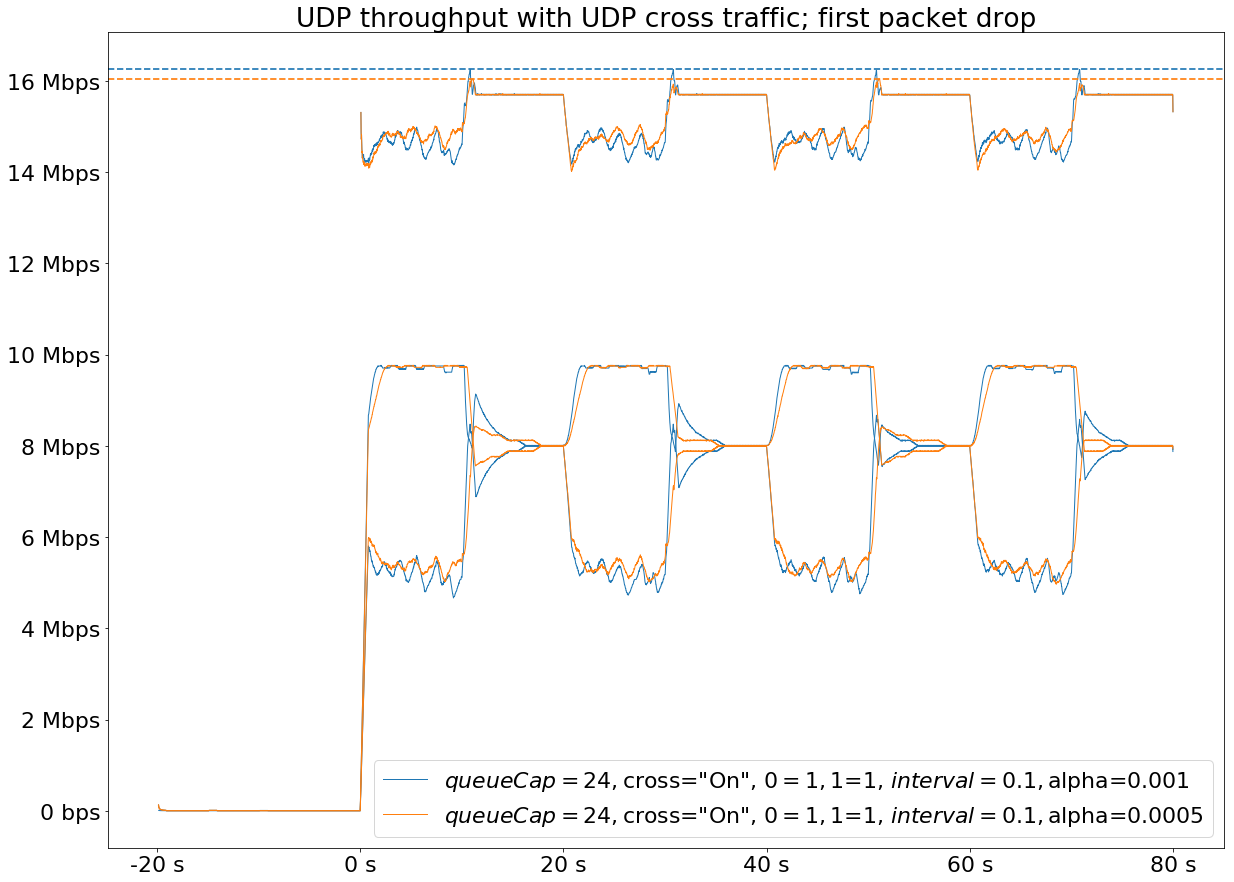

In [84]:
# Trying to plot throughput until first drop, plot the first drop time (at least as a tick on X-axis)

final_version = False
save_figure = False

plt.rcParams["figure.figsize"] =(20,15)
plt.rcParams.update({'font.size': 22})
formatter_x = EngFormatter(unit='s')
formatter_y = EngFormatter(unit='bps')

# max_min = vectors_arranged.drop_min_vectime.max()
max_min = 0
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter_x)
# ax.set_yscale('log')
ax.yaxis.set_major_formatter(formatter_y)
if(not final_version):
    ax.set_title("UDP throughput with UDP cross traffic; first packet drop")
legend = list()
# print(vectors_arranged[(vectors_arranged.queueCap > 1) &  (vectors_arranged.cross == "\"On\"")].columns)
for row in vectors_toPlot[(vectors_toPlot.queueCap < 50) & (vectors_toPlot.alpha < 0.005) & (vectors_toPlot.alpha > 0.0001) & (vectors_toPlot.interval > 0.09) &  (vectors_toPlot.cross == "\"On\"")].itertuples():
#     print(row)

#     appThrough = row._5 # Hexagon.client499.app[0].rcvdPk:vector(packetBytes)
    appThrough = row.Hexagon_client499_app_0__rcvdPk_vector_packetBytes_
#     bottom = row._14   
    bottom = row.Hexagon_routerCore4_eth_1__encap_decapPk_vector_packetBytes_
    
#     top = row._15
    top = row.Hexagon_routerCore4_eth_2__encap_decapPk_vector_packetBytes_
#     print(top)

    itervar = row.iterationvars
#     print(itervar)

    
#     appThroughputValue = row[3]
#     appThroughputIndex = row[2]

#     hasDmpr = row.hasDmpr
    hasDmpr = True
    
#     max_min = max(max_min, drop_min_vectime)
    if(final_version):
        if(hasDmpr):
            legend.append("With mechanism")
        else:
            legend.append("Without mechanism")
    else: 
        legend.append(itervar)
#         legend.append(itervar + str(" top"))
#         legend.append(itervar + str(" bottom"))
    
    color = next(ax._get_lines.prop_cycler)['color']
    
    appThroughResampled = appThrough.resample('20ms',label='right').sum()*8*50
    appThroughRolling = appThroughResampled.rolling( window=40, min_periods=3).mean()
    
    plt.plot(appThroughRolling.index.total_seconds() - 20, appThroughRolling.values,  linewidth=1, color=color)
    

    
    topResampled = top.resample('20ms',label='right').sum()*8*50
    topRolling = topResampled.rolling( window=40, min_periods=3).mean()
    
    plt.plot(topRolling.index.total_seconds() - 20, topRolling.values,  linewidth=1, color=color,label='_nolegend_')
    
    bottomResampled = bottom.resample('20ms',label='right').sum()*8*50
    bottomRolling = bottomResampled.rolling( window=40, min_periods=3).mean()
    
    plt.plot(bottomRolling.index.total_seconds() - 20, bottomRolling.values,  linewidth=1, color=color,label='_nolegend_')
    

        #max line
#     print(appThroughRolling.fillna(0).values.max())
#     print(np.max(appThroughRolling.values))
    plt.axhline(appThroughRolling.fillna(0).values.max(), linestyle='dashed', linewidth=1.7, color=color, label='_nolegend_')
#     legend.append(itervar + "; max=" + formatter_y(appThroughRolling.fillna(0).values.max()))

#     print_series = pd.Series(appThroughputValue, index = pd.to_timedelta(appThroughputIndex,  unit='s'))
# #     print_series = trimTimeDeltaSeries(print_series, after=pd.to_timedelta(drop_min_vectime, unit='s'))
#     result = print_series.resample('10ms',label='right').sum()*8*100
#     resultPlot = result.rolling( window=40, min_periods=3).mean()

# #     resultPlot = print_series.cumsum()
# #     resultPlot = trimTimeDeltaSeries(resultPlot, after=pd.to_timedelta(drop_min_vectime, unit='s'))
    
    
#     #get closest index from resultPlot
# #     idx = resultPlot.index.get_loc(pd.to_timedelta(drop_min_vectime, unit='s'), 'nearest')

# #     meanLine = result.rolling(window=result.size, min_periods=10).mean()
#     start = print_series.index.min()
#     end = print_series.index.max()
#     avg_speed = 100*8*1000*1000/(end.total_seconds()-20.0)

#     print(meanLine)

#     plt.plot(resultPlot.index.total_seconds() - 20, resultPlot.values,  linewidth=1,) #
    
#     plt.plot(meanLine.index.total_seconds(), meanLine.values, color='red')
#     plt.plot(resultPlot.index.total_seconds(), np.ndarray((resultPlot.size), dtype=meanPoint))
#     dropArray = np.concatenate((row[7], row[8], row[9], row[10]))



#     ax.scatter(dropArray, np.ones(shape=(dropArray.size, )))
#     ax.scatter(dropArray, resultPlot[resultPlot.index.get_loc(key=dropArray,method="nearest")], color="green")
    # vertical dotted line originating at mean value
    
    
#     #average line
#     meanPoint = resultPlot.mean()
#     meanPoint_text = formatter_y(avg_speed)
#     legend.append(itervar + "; avg=" + meanPoint_text)
#     plt.axhline(meanPoint, linestyle='dashed', linewidth=0.7)
    
# #     print(row.iterationvars)
    
#     fig.savefig("fig/single_conn/Full_SingleConn_"+row[12] + ".png", bbox_inches='tight') 



# plt.xlim(left= 0.0,right=max_min + 0.11 - 20)
ax.legend(legend)
plt.show()
if(save_figure):
    if(final_version):
        fig.savefig("fig/single_conn/Hex_UdpEcn.png", bbox_inches='tight') 
    else:
        ax.legend(legend)
        fig.savefig("fig/single_conn/Backup_UdpEcn.png", bbox_inches='tight')

In [62]:
vectors_toPlot

,queueCap,cross,alpha,interval,iterationvars,Hexagon_client499_app_0__rcvdPk_vector_packetBytes_,Hexagon_routerCore1_dmpr_congLevel__192_168_4_0_eth_1__vector,Hexagon_routerCore1_dmpr_congLevel__192_168_4_0_eth_2__vector,Hexagon_routerCore1_dmpr_fwdCongLevel__192_168_4_0_eth_1__vector,Hexagon_routerCore1_dmpr_fwdCongLevel__192_168_4_0_eth_2__vector,Hexagon_routerCore1_dmpr_inUseCongLevel__192_168_4_0_eth_1__vector,Hexagon_routerCore1_dmpr_inUseCongLevel__192_168_4_0_eth_2__vector,Hexagon_routerCore1_eth_1__queue_red_packetDropCongestion_vector_packetBytes_,Hexagon_routerCore1_eth_2__queue_red_packetDropCongestion_vector_packetBytes_,Hexagon_routerCore2_eth_2__queue_red_packetDropCongestion_vector_packetBytes_,Hexagon_routerCore4_eth_1__encap_decapPk_vector_packetBytes_,Hexagon_routerCore4_eth_2__encap_decapPk_vector_packetBytes_
run,,,,,,,,,,,,,,,,,
HexSingleConnUdpRedUdpCrossIntervalAlpha-0-20190227-17:43:19-29340,24.0,"""On""",0.0300,0.01,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv...",0 00:00:20.020667 1472....,0 00:00:20.025851 0.0...,0 00:00:20.025974 0.0...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 0.0...,0 00:00:20.006390 0.0...,0 00:00:21.547994 1504....,0 00:00:20.380244 1504....,0 00:00:20.237444 1504....,0 00:00:00.097418 64....,0 00:00:00.112811 68....
HexSingleConnUdpRedUdpCrossIntervalAlpha-1-20190227-17:45:46-29340,24.0,"""On""",0.0200,0.01,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv...",0 00:00:20.019442 1472....,0 00:00:20.024996 ...,0 00:00:20.024627 ...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 ...,0 00:00:20.006390 ...,NaN,0 00:00:20.418494 1504....,0 00:00:20.094464 1504....,0 00:00:00.110316 68....,0 00:00:00.103700 68....
HexSingleConnUdpRedUdpCrossIntervalAlpha-10-20190227-17:43:19-29323,24.0,"""On""",0.0050,0.02,"$queueCap=24, $cross=""On"", $0=1, $1=1, $interv...",0 00:00:20.020667 1472....,0 00:00:20.025851 ...,0 00:00:20.025974 ...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 ...,0 00:00:20.006390 ...,NaN,0 00:00:20.913494 1504....,0 00:00:20.082464 1504....,0 00:00:00.100555 68....,0 00:00:00.110343 64....
HexSingleConnUdpRedUdpCrossIntervalAlpha-100-20190227-17:43:19-29359,24.0,"""Off""",0.0100,0.05,"$queueCap=24, $cross=""Off"", $0=default, $1=def...",0 00:00:20.019196 1472....,0 00:00:20.024381 0.0 00:0...,0 00:00:20.024504 0.0 00:0...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,NaN,NaN,NaN,0 00:00:00.104790 68....,0 00:00:00.105861 68....
HexSingleConnUdpRedUdpCrossIntervalAlpha-101-20190227-17:45:40-29359,24.0,"""Off""",0.0050,0.05,"$queueCap=24, $cross=""Off"", $0=default, $1=def...",0 00:00:20.019196 1472....,0 00:00:20.024381 0.0 00:0...,0 00:00:20.024504 0.0 00:0...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,NaN,NaN,NaN,0 00:00:00.103958 64....,0 00:00:00.086268 64....
HexSingleConnUdpRedUdpCrossIntervalAlpha-102-20190227-17:48:01-29359,24.0,"""Off""",0.0010,0.05,"$queueCap=24, $cross=""Off"", $0=default, $1=def...",0 00:00:20.019196 1472....,0 00:00:20.024381 0.0 00:0...,0 00:00:20.024504 0.0 00:0...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,NaN,NaN,NaN,0 00:00:00.110080 64....,0 00:00:00.091611 64....
HexSingleConnUdpRedUdpCrossIntervalAlpha-103-20190227-17:50:23-29359,24.0,"""Off""",0.0005,0.05,"$queueCap=24, $cross=""Off"", $0=default, $1=def...",0 00:00:20.019442 1472....,0 00:00:20.024873 0.0 00:0...,0 00:00:20.024627 0.0 00:0...,0 00:00:20.006267 0.0 00:0...,0 00:00:20.006513 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,0 00:00:20.006390 0.0 00:0...,NaN,NaN,NaN,0 00:00:00.094874 64....,0 00:00:00.111242 68....
HexSingleConnUdpRedUdpCrossIntervalAlpha-104-20190227-17:52:46-29359,24.0,"""Off""",0.0001,0.05,"$queueCap=24, $cross=""Off"", $0=defaul

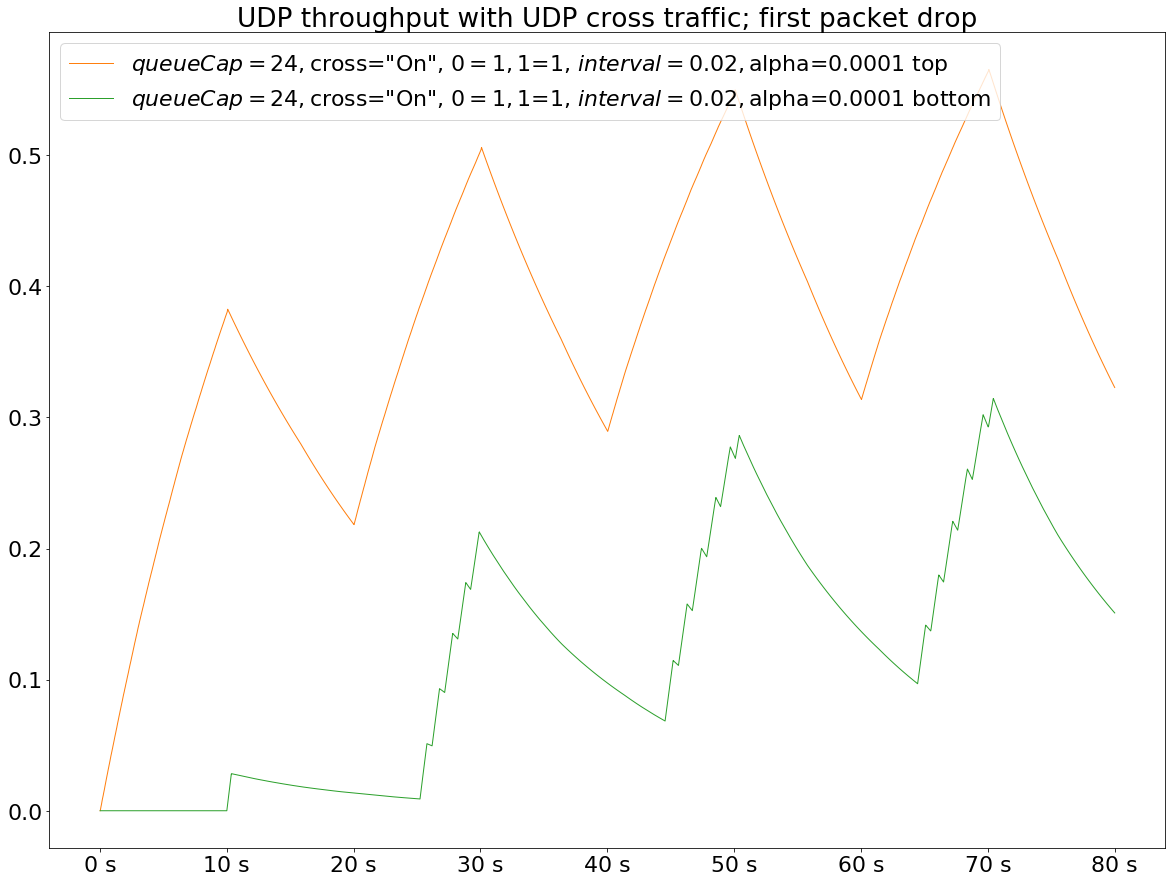

In [81]:
# Trying to plot throughput until first drop, plot the first drop time (at least as a tick on X-axis)

final_version = False
save_figure = False

plt.rcParams["figure.figsize"] =(20,15)
plt.rcParams.update({'font.size': 22})
formatter_x = EngFormatter(unit='s')
# formatter_y = EngFormatter(unit='bps')

# max_min = vectors_arranged.drop_min_vectime.max()
max_min = 0
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter_x)
# ax.set_yscale('log')
# ax.yaxis.set_major_formatter(formatter_y)
if(not final_version):
    ax.set_title("UDP throughput with UDP cross traffic; first packet drop")
legend = list()
# print(vectors_arranged[(vectors_arranged.queueCap > 1) &  (vectors_arranged.cross == "\"On\"")].columns)
for row in vectors_toPlot[(vectors_toPlot.queueCap < 50) & (vectors_toPlot.alpha == 0.0001)  & (vectors_toPlot.interval == 0.02) &  (vectors_toPlot.cross == "\"On\"")].itertuples():
#     print(row)

#     appThrough = row._5 # Hexagon.client499.app[0].rcvdPk:vector(packetBytes)
#     appThrough = row.Hexagon_client499_app_0__rcvdPk_vector_packetBytes_
#     bottom = row._14   
    bottom = row.Hexagon_routerCore1_dmpr_congLevel__192_168_4_0_eth_1__vector
    
#     top = row._15
    top = row.Hexagon_routerCore1_dmpr_congLevel__192_168_4_0_eth_2__vector


    itervar = row.iterationvars

#     hasDmpr = row.hasDmpr
    hasDmpr = True
    
#     max_min = max(max_min, drop_min_vectime)
    if(final_version):
        if(hasDmpr):
            legend.append("With mechanism")
        else:
            legend.append("Without mechanism")
    else: 
#         legend.append(itervar)
        legend.append(itervar + str(" top"))
        legend.append(itervar + str(" bottom"))
    
    color = next(ax._get_lines.prop_cycler)['color']
    
#     appThroughResampled = appThrough.resample('20ms',label='right').sum()*8*50
#     appThroughRolling = appThroughResampled.rolling( window=40, min_periods=3).mean()
    
#     plt.plot(appThroughRolling.index.total_seconds() - 20, appThroughRolling.values,  linewidth=1, color=color)
    

    
#     topResampled = top.resample('20ms',label='right').sum()*8*50
#     topRolling = topResampled.rolling( window=40, min_periods=3).mean()
    
    plt.plot(top.index.total_seconds() - 20, top.values,  linewidth=1, )
    
#     bottomResampled = bottom.resample('20ms',label='right').sum()*8*50
#     bottomRolling = bottomResampled.rolling( window=40, min_periods=3).mean()
    
    plt.plot(bottom.index.total_seconds() - 20, bottom.values,  linewidth=1,)
    

        #max line
#     print(appThroughRolling.fillna(0).values.max())
#     print(np.max(appThroughRolling.values))
#     plt.axhline(appThroughRolling.fillna(0).values.max(), linestyle='dashed', linewidth=1.7, color=color, label='_nolegend_')
#     legend.append(itervar + "; max=" + formatter_y(appThroughRolling.fillna(0).values.max()))

#     print_series = pd.Series(appThroughputValue, index = pd.to_timedelta(appThroughputIndex,  unit='s'))
# #     print_series = trimTimeDeltaSeries(print_series, after=pd.to_timedelta(drop_min_vectime, unit='s'))
#     result = print_series.resample('10ms',label='right').sum()*8*100
#     resultPlot = result.rolling( window=40, min_periods=3).mean()

# #     resultPlot = print_series.cumsum()
# #     resultPlot = trimTimeDeltaSeries(resultPlot, after=pd.to_timedelta(drop_min_vectime, unit='s'))
    
    
#     #get closest index from resultPlot
# #     idx = resultPlot.index.get_loc(pd.to_timedelta(drop_min_vectime, unit='s'), 'nearest')

# #     meanLine = result.rolling(window=result.size, min_periods=10).mean()
#     start = print_series.index.min()
#     end = print_series.index.max()
#     avg_speed = 100*8*1000*1000/(end.total_seconds()-20.0)

#     print(meanLine)

#     plt.plot(resultPlot.index.total_seconds() - 20, resultPlot.values,  linewidth=1,) #
    
#     plt.plot(meanLine.index.total_seconds(), meanLine.values, color='red')
#     plt.plot(resultPlot.index.total_seconds(), np.ndarray((resultPlot.size), dtype=meanPoint))
#     dropArray = np.concatenate((row[7], row[8], row[9], row[10]))



#     ax.scatter(dropArray, np.ones(shape=(dropArray.size, )))
#     ax.scatter(dropArray, resultPlot[resultPlot.index.get_loc(key=dropArray,method="nearest")], color="green")
    # vertical dotted line originating at mean value
    
    
#     #average line
#     meanPoint = resultPlot.mean()
#     meanPoint_text = formatter_y(avg_speed)
#     legend.append(itervar + "; avg=" + meanPoint_text)
#     plt.axhline(meanPoint, linestyle='dashed', linewidth=0.7)
    
# #     print(row.iterationvars)
    
#     fig.savefig("fig/single_conn/Full_SingleConn_"+row[12] + ".png", bbox_inches='tight') 



# plt.xlim(left= 9.0,right=20)
ax.legend(legend)
plt.show()
if(save_figure):
    if(final_version):
        fig.savefig("fig/single_conn/Hex_UdpEcn.png", bbox_inches='tight') 
    else:
        ax.legend(legend)
        fig.savefig("fig/single_conn/Backup_UdpEcn.png", bbox_inches='tight')

In [15]:

result = vectors.apply(lambda x: pd.Series(x["vecvalue"].tolist(), index = pd.to_timedelta(x["vectime"].tolist(),  unit='s')), axis=1)



In [234]:
# result

In [10]:
# series_df = pd.DataFrame(columns=["serz"])
for row in vectors[["run", "vecvalue", "vectime"]].head(1).itertuples():
    print (row.Index)
    tmp= pd.Series(row.vecvalue, index=pd.to_timedelta(row.vectime, unit="s"))
#     print(tmp)
#     tmp.name = "serz"
    vectors.loc[row.Index,"hovno"]=tmp
    vectors.insert(loc=1 column="hovno", value=tmp)
#     print(series_df.loc[row.Index])

SyntaxError: invalid syntax (<ipython-input-10-2a6dda84d100>, line 8)

In [16]:
# loaded_csv.loc[loaded_csv.type=="vector"]
# vectors = loaded_csv.loc[loaded_csv.type=="vector", ['run', 'module' , 'name',  'vectime', 'vecvalue', 'iterationvars']]
# vectors["module_name"] = vectors["module"].map(str) + "." +  vectors["name"]
vectors.loc[vectors.module.str.contains("Hexagon.routerCore4.eth\[.*\]")]
vectors.pivot(index = 'run', columns = 'module_name', values = ['vectime', 'vecvalue'])

vectime  \
module_name                                        Hexagon.client499.app[0].rcvdPk:vector(packetBytes)   
run                                                                                                      
HexSingleConnUdpRedUdpCross-0-20190124-15:58:48...  [20.0206672, 20.02079024, 20.02091328, 20.0210...    
HexSingleConnUdpRedUdpCross-1-20190124-15:58:48...  [20.0227824, 20.02290544, 20.02302848, 20.0249...    
HexSingleConnUdpRedUdpCross-2-20190124-15:58:48...  [20.0191968, 20.01931984, 20.01944288, 20.0195...    
HexSingleConnUdpRedUdpCross-3-20190124-15:58:48...  [20.0191968, 20.01931984, 20.01944288, 20.0195...    
HexSingleConnUdpRedUdpCross-4-20190124-15:58:48...  [20.01931984, 20.01944288, 20.01956592, 20.019...    
HexSingleConnUdpRedUdpCross-5-20190124-15:58:48...  [20.0218976, 20.02202064, 20.02214368, 20.0240...    
HexSingleConnUdpRedUdpCross-6-20190124-15:58:48...  [20.0191968, 20.01931984, 20.01944288, 20.0195...    
HexSingleConnUdpRedUdpCross-7-20190124-15:58:48...  [20.0191968, 20.01931984, 20.01944288, 20.0195...    

                                                                                                       \
module_name                                          Hexagon.routerCore1.dmpr.congLevel.eth[1]:vector   
run                                                                                                     
HexSingleConnUdpRedUdpCross-0-20190124-15:58:48...  [20.02585152, 20.02622064, 20.02646672, 20.027...   
HexSingleConnUdpRedUdpCross-1-20190124-15:58:48...                                                NaN   
HexSingleConnUdpRedUdpCross-2-20190124-15:58:48...  [20.02438112, 20.0246272, 20.02487328, 20.0251...   
HexSingleConnUdpRedUdpCross-3-20190124-15:58:48...                                                NaN   
HexSingleConnUdpRedUdpCross-4-20190124-15:58:48...  [20.02475024, 20.02511936, 20.02552576, 20.027...   
HexSingleConnUdpRedUdpCross-5-20190124-15:58:48...                                                NaN   
HexSingleConnUdpRedUdpCross-6-20190124-15:58:48...  [20.02438112, 20.0246272, 20.02487328, 20.0251...   
HexSingleConnUdpRedUdpCross-7-20190124-15:58:48...                                                NaN   

                                                                                                       \
module_name                                          Hexagon.routerCore1.dmpr.congLevel.eth[2]:vector   
run                                                                                                     
HexSingleConnUdpRedUdpCross-0-20190124-15:58:48...  [20.02597456, 20.0260976, 20.02634368, 20.0265...   
HexSingleConnUdpRedUdpCross-1-20190124-15:58:48...                                                NaN   
HexSingleConnUdpRedUdpCross-2-20190124-15:58:48...  [20.02450416, 20.02475024, 20.02499632, 20.025...   
HexSingleConnUdpRedUdpCross-3-20190124-15:58:48...                                                NaN   
HexSingleConnUdpRedUdpCross-4-20190124-15:58:48...  [20.02450416, 20.0246272, 20.02487328, 20.0249...   
HexSingleConnUdpRedUdpCross-5-20190124-15:58:48...                                                NaN   
HexSingleConnUdpRedUdpCross-6-20190124-15:58:48...  [20.02450416, 20.02475024, 20.02499632, 20.025...   
HexSingleConnUdpRedUdpCross-7-20190124-15:58:48...                                                NaN   

                                                                                                          \
module_name                                        Hexagon.routerCore1.dmpr.inUseCongLevel.eth[0]:vector   
run                                                                                                        
HexSingleConnUdpRedUdpCross-0-20190124-15:58:48...  [0.117492607824, 5.118786304792, 10.1046395218...      
HexSingleConnUdpRedUdpCross-1-20190124-15:58:48...                                                NaN      
HexSingleConnUdpRedUdpCross-2-20190124-15:58:48...  [0.110728090348, 5.10717

In [17]:
# pd.set_option('max_colwidth', 80)
# save column order
col_order= loaded_csv.columns.tolist()
#create dictionary of reduce functions           
agg_dict = {"type": "first","attrname": "first", "attrvalue" : "first","value": "first","vectime": lambda x: list(np.hstack(x)), "vecvalue": lambda x: list(np.hstack(x)), "cross": "first","hasDmpr": "first","queueCap": "first","iterationvars": "first"}
#get copy of vectors
df_slice = loaded_csv[(loaded_csv.type=="vector")]

loaded_csv = df_slice.groupby(['run', 'module', 'name'], as_index = False).agg(agg_dict) 
loaded_csv = loaded_csv[col_order]
loaded_csv.head(25)


,run,type,module,name,attrname,attrvalue,value,vectime,vecvalue,cross,hasDmpr,queueCap,iterationvars
0,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.client499.app[0],rcvdPk:vector(packetBytes),NaN,None,NaN,"[20.0206672, 20.02079024, 20.02091328, 20.0210...","[1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."
1,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.routerCore1.dmpr,congLevel.eth[1]:vector,NaN,None,NaN,"[20.02585152, 20.02622064, 20.02646672, 20.027...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."
2,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.routerCore1.dmpr,congLevel.eth[2]:vector,NaN,None,NaN,"[20.02597456, 20.0260976, 20.02634368, 20.0265...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."
3,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.routerCore1.dmpr,inUseCongLevel.eth[0]:vector,NaN,None,NaN,"[0.117492607824, 5.118786304792, 10.1046395218...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."
4,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.routerCore1.dmpr,inUseCongLevel.eth[1]:vector,NaN,None,NaN,"[0.117492607824, 5.117492607824, 10.1046395218...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.1412659743, 0.3857...","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."
5,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.routerCore1.dmpr,inUseCongLevel.eth[2]:vector,NaN,None,NaN,"[0.125825017754, 5.118786304792, 10.1046395218...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."
6,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.routerCore1.eth[1].queue.red,packetDropCongestion:vector(packetBytes),NaN,None,NaN,"[20.57374416, 20.82499416, 20.82874416, 20.834...","[1504.0, 1504.0, 1504.0, 1504.0, 1504.0, 1504....","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."
7,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.routerCore1.eth[2].queue.red,packetDropCongestion:vector(packetBytes),NaN,None,NaN,"[20.20924416, 20.21824416, 20.22799416, 20.425...","[1504.0, 1504.0, 1504.0, 1504.0, 1504.0, 1504....","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."
8,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.routerCore2.eth[2].queue.red,packetDropCongestion:vector(packetBytes),NaN,None,NaN,"[20.09104416, 20.11321496, 20.28796496, 20.292...","[1504.0, 1504.0, 1504.0, 1504.0, 1504.0, 1504....","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."
9,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.routerCore4.eth[1].encap,decapPk:vector(packetBytes),NaN,None,NaN,"[0.097418980613, 0.108882304792, 0.11102310479...","[64.0, 52.0, 72.0, 52.0, 56.0, 84.0, 120.0, 10...","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."


In [18]:
df_slice = loaded_csv[(loaded_csv.type=="vector")]
df_slice

,run,type,module,name,attrname,attrvalue,value,vectime,vecvalue,cross,hasDmpr,queueCap,iterationvars
0,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.client499.app[0],rcvdPk:vector(packetBytes),NaN,None,NaN,"[20.0206672, 20.02079024, 20.02091328, 20.0210...","[1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."
1,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.routerCore1.dmpr,congLevel.eth[1]:vector,NaN,None,NaN,"[20.02585152, 20.02622064, 20.02646672, 20.027...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."
2,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.routerCore1.dmpr,congLevel.eth[2]:vector,NaN,None,NaN,"[20.02597456, 20.0260976, 20.02634368, 20.0265...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."
3,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.routerCore1.dmpr,inUseCongLevel.eth[0]:vector,NaN,None,NaN,"[0.117492607824, 5.118786304792, 10.1046395218...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."
4,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.routerCore1.dmpr,inUseCongLevel.eth[1]:vector,NaN,None,NaN,"[0.117492607824, 5.117492607824, 10.1046395218...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.1412659743, 0.3857...","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."
5,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.routerCore1.dmpr,inUseCongLevel.eth[2]:vector,NaN,None,NaN,"[0.125825017754, 5.118786304792, 10.1046395218...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."
6,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.routerCore1.eth[1].queue.red,packetDropCongestion:vector(packetBytes),NaN,None,NaN,"[20.57374416, 20.82499416, 20.82874416, 20.834...","[1504.0, 1504.0, 1504.0, 1504.0, 1504.0, 1504....","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."
7,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.routerCore1.eth[2].queue.red,packetDropCongestion:vector(packetBytes),NaN,None,NaN,"[20.20924416, 20.21824416, 20.22799416, 20.425...","[1504.0, 1504.0, 1504.0, 1504.0, 1504.0, 1504....","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."
8,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.routerCore2.eth[2].queue.red,packetDropCongestion:vector(packetBytes),NaN,None,NaN,"[20.09104416, 20.11321496, 20.28796496, 20.292...","[1504.0, 1504.0, 1504.0, 1504.0, 1504.0, 1504....","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."
9,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,vector,Hexagon.routerCore4.eth[1].encap,decapPk:vector(packetBytes),NaN,None,NaN,"[0.097418980613, 0.108882304792, 0.11102310479...","[64.0, 52.0, 72.0, 52.0, 56.0, 84.0, 120.0, 10...","""On""",True,24.0,"$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp..."


In [19]:
#filter

# type(loaded_csv[(loaded_csv.type=="vector") ].vecvalue.iloc[1])
# loaded_csv.head()
res = df_slice
print(len(res))
print(res[res.duplicated(subset=['run', 'module',], keep=False)])
# res[res.duplicated(subset=['run', 'module'], keep=False)]

# loaded_csv.columns.tolist()

56
                                                  run    type  \
1   HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...  vector   
2   HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...  vector   
3   HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...  vector   
4   HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...  vector   
5   HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...  vector   
17  HexSingleConnUdpRedUdpCross-2-20190124-15:58:4...  vector   
18  HexSingleConnUdpRedUdpCross-2-20190124-15:58:4...  vector   
19  HexSingleConnUdpRedUdpCross-2-20190124-15:58:4...  vector   
20  HexSingleConnUdpRedUdpCross-2-20190124-15:58:4...  vector   
21  HexSingleConnUdpRedUdpCross-2-20190124-15:58:4...  vector   
29  HexSingleConnUdpRedUdpCross-4-20190124-15:58:4...  vector   
30  HexSingleConnUdpRedUdpCross-4-20190124-15:58:4...  vector   
31  HexSingleConnUdpRedUdpCross-4-20190124-15:58:4...  vector   
32  HexSingleConnUdpRedUdpCross-4-20190124-15:58:4...  vector   
33  HexSingleConnUdpRe

In [20]:
# loaded_csv['hasDmpr']
#get vectors
vectors = loaded_csv[loaded_csv.type=="vector"]
#filter the entries so that only one 'run' for combinations of 'values' exists
# for example use module that have only one statistic
vectors = vectors[vectors.module=="Hexagon.client499.app[0]"]
itervar_columns = vectors.pivot(index = 'run', columns = 'module', values = ['hasDmpr', 'queueCap', 'cross'])
# print(itervar_columns)
# drop the 'module_name' level (or is it named index?)
itervar_columns = itervar_columns.xs('Hexagon.client499.app[0]', axis=1, level=1, drop_level=True)
itervar_columns

,hasDmpr,queueCap,cross
run,,,
HexSingleConnUdpRedUdpCross-0-20190124-15:58:48-27631,True,24,"""On"""
HexSingleConnUdpRedUdpCross-1-20190124-15:58:48-27626,False,24,"""On"""
HexSingleConnUdpRedUdpCross-2-20190124-15:58:48-27614,True,24,"""Off"""
HexSingleConnUdpRedUdpCross-3-20190124-15:58:48-27625,False,24,"""Off"""
HexSingleConnUdpRedUdpCross-4-20190124-15:58:48-27630,True,50,"""On"""
HexSingleConnUdpRedUdpCross-5-20190124-15:58:48-27629,False,50,"""On"""
HexSingleConnUdpRedUdpCross-6-20190124-15:58:48-27632,True,50,"""Off"""
HexSingleConnUdpRedUdpCross-7-20190124-15:58:48-27624,False,50,"""Off"""


In [21]:
vectors = loaded_csv.loc[loaded_csv.type=="vector", ['run', 'module' , 'name',  'vectime', 'vecvalue', 'iterationvars']]
vectors["module_name"] = vectors["module"].map(str) + "." +  vectors["name"]

vectors.head(25)




,run,module,name,vectime,vecvalue,iterationvars,module_name
0,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,Hexagon.client499.app[0],rcvdPk:vector(packetBytes),"[20.0206672, 20.02079024, 20.02091328, 20.0210...","[1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....","$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp...",Hexagon.client499.app[0].rcvdPk:vector(packetB...
1,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,Hexagon.routerCore1.dmpr,congLevel.eth[1]:vector,"[20.02585152, 20.02622064, 20.02646672, 20.027...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp...",Hexagon.routerCore1.dmpr.congLevel.eth[1]:vector
2,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,Hexagon.routerCore1.dmpr,congLevel.eth[2]:vector,"[20.02597456, 20.0260976, 20.02634368, 20.0265...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp...",Hexagon.routerCore1.dmpr.congLevel.eth[2]:vector
3,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,Hexagon.routerCore1.dmpr,inUseCongLevel.eth[0]:vector,"[0.117492607824, 5.118786304792, 10.1046395218...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp...",Hexagon.routerCore1.dmpr.inUseCongLevel.eth[0]...
4,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,Hexagon.routerCore1.dmpr,inUseCongLevel.eth[1]:vector,"[0.117492607824, 5.117492607824, 10.1046395218...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.1412659743, 0.3857...","$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp...",Hexagon.routerCore1.dmpr.inUseCongLevel.eth[1]...
5,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,Hexagon.routerCore1.dmpr,inUseCongLevel.eth[2]:vector,"[0.125825017754, 5.118786304792, 10.1046395218...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp...",Hexagon.routerCore1.dmpr.inUseCongLevel.eth[2]...
6,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,Hexagon.routerCore1.eth[1].queue.red,packetDropCongestion:vector(packetBytes),"[20.57374416, 20.82499416, 20.82874416, 20.834...","[1504.0, 1504.0, 1504.0, 1504.0, 1504.0, 1504....","$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp...",Hexagon.routerCore1.eth[1].queue.red.packetDro...
7,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,Hexagon.routerCore1.eth[2].queue.red,packetDropCongestion:vector(packetBytes),"[20.20924416, 20.21824416, 20.22799416, 20.425...","[1504.0, 1504.0, 1504.0, 1504.0, 1504.0, 1504....","$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp...",Hexagon.routerCore1.eth[2].queue.red.packetDro...
8,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,Hexagon.routerCore2.eth[2].queue.red,packetDropCongestion:vector(packetBytes),"[20.09104416, 20.11321496, 20.28796496, 20.292...","[1504.0, 1504.0, 1504.0, 1504.0, 1504.0, 1504....","$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp...",Hexagon.routerCore2.eth[2].queue.red.packetDro...
9,HexSingleConnUdpRedUdpCross-0-20190124-15:58:4...,Hexagon.routerCore4.eth[1].encap,decapPk:vector(packetBytes),"[0.097418980613, 0.108882304792, 0.11102310479...","[64.0, 52.0, 72.0, 52.0, 56.0, 84.0, 120.0, 10...","$queueCap=24, $cross=""On"", $0=1, $1=1, $hasDmp...",Hexagon.routerCore4.eth[1].encap.decapPk:vecto...


In [22]:
vectors_toPlot=vectors.pivot(index = 'run', columns = 'module_name', values = ['vecvalue', 'vectime', 'iterationvars'])
vectors_toPlot = vectors_toPlot.apply(lambda x:x.apply(lambda x:[] if isnan(x) else x))
vectors_toPlot.head()


vecvalue  \
module_name                                        Hexagon.client499.app[0].rcvdPk:vector(packetBytes)   
run                                                                                                      
HexSingleConnUdpRedUdpCross-0-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....    
HexSingleConnUdpRedUdpCross-1-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....    
HexSingleConnUdpRedUdpCross-2-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....    
HexSingleConnUdpRedUdpCross-3-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....    
HexSingleConnUdpRedUdpCross-4-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....    

                                                                                                       \
module_name                                          Hexagon.routerCore1.dmpr.congLevel.eth[1]:vector   
run                                                                                                     
HexSingleConnUdpRedUdpCross-0-20190124-15:58:48...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
HexSingleConnUdpRedUdpCross-1-20190124-15:58:48...                                                 []   
HexSingleConnUdpRedUdpCross-2-20190124-15:58:48...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
HexSingleConnUdpRedUdpCross-3-20190124-15:58:48...                                                 []   
HexSingleConnUdpRedUdpCross-4-20190124-15:58:48...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                                                       \
module_name                                          Hexagon.routerCore1.dmpr.congLevel.eth[2]:vector   
run                                                                                                     
HexSingleConnUdpRedUdpCross-0-20190124-15:58:48...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
HexSingleConnUdpRedUdpCross-1-20190124-15:58:48...                                                 []   
HexSingleConnUdpRedUdpCross-2-20190124-15:58:48...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
HexSingleConnUdpRedUdpCross-3-20190124-15:58:48...                                                 []   
HexSingleConnUdpRedUdpCross-4-20190124-15:58:48...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                                                          \
module_name                                        Hexagon.routerCore1.dmpr.inUseCongLevel.eth[0]:vector   
run                                                                                                        
HexSingleConnUdpRedUdpCross-0-20190124-15:58:48...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      
HexSingleConnUdpRedUdpCross-1-20190124-15:58:48...                                                 []      
HexSingleConnUdpRedUdpCross-2-20190124-15:58:48...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      
HexSingleConnUdpRedUdpCross-3-20190124-15:58:48...                                                 []      
HexSingleConnUdpRedUdpCross-4-20190124-15:58:48...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      

                                                                                                          \
module_name                                        Hexagon.routerCore1.dmpr.inUseCongLevel.eth[1]:vector   
run                                                                                                        
HexSingleConnUdpRedUdpCross-0-20190124-15:58:48...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.1412659743, 0.3857...      
HexSingleConnUdpRedUdpCross-1-20190124-15:58:48...                                                 []      
HexSingleConnUdpRedUdpCross-2-20190124-15:58:48...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      
HexSingleConnUdpRedUdpCross-3-20190124-15:58:48...

In [23]:
vectors_arranged = vectors_toPlot.swaplevel(0,1,axis=1).sort_index(1)
vectors_arranged

module_name                                        Hexagon.client499.app[0].rcvdPk:vector(packetBytes)  \
                                                                                         iterationvars   
run                                                                                                      
HexSingleConnUdpRedUdpCross-0-20190124-15:58:48...  $queueCap=24, $cross="On", $0=1, $1=1, $hasDmp...    
HexSingleConnUdpRedUdpCross-1-20190124-15:58:48...  $queueCap=24, $cross="On", $0=1, $1=1, $hasDmp...    
HexSingleConnUdpRedUdpCross-2-20190124-15:58:48...  $queueCap=24, $cross="Off", $0=default, $1=def...    
HexSingleConnUdpRedUdpCross-3-20190124-15:58:48...  $queueCap=24, $cross="Off", $0=default, $1=def...    
HexSingleConnUdpRedUdpCross-4-20190124-15:58:48...  $queueCap=50, $cross="On", $0=1, $1=1, $hasDmp...    
HexSingleConnUdpRedUdpCross-5-20190124-15:58:48...  $queueCap=50, $cross="On", $0=1, $1=1, $hasDmp...    
HexSingleConnUdpRedUdpCross-6-20190124-15:58:48...  $queueCap=50, $cross="Off", $0=default, $1=def...    
HexSingleConnUdpRedUdpCross-7-20190124-15:58:48...  $queueCap=50, $cross="Off", $0=default, $1=def...    

module_name                                                                                            \
                                                                                              vectime   
run                                                                                                     
HexSingleConnUdpRedUdpCross-0-20190124-15:58:48...  [20.0206672, 20.02079024, 20.02091328, 20.0210...   
HexSingleConnUdpRedUdpCross-1-20190124-15:58:48...  [20.0227824, 20.02290544, 20.02302848, 20.0249...   
HexSingleConnUdpRedUdpCross-2-20190124-15:58:48...  [20.0191968, 20.01931984, 20.01944288, 20.0195...   
HexSingleConnUdpRedUdpCross-3-20190124-15:58:48...  [20.0191968, 20.01931984, 20.01944288, 20.0195...   
HexSingleConnUdpRedUdpCross-4-20190124-15:58:48...  [20.01931984, 20.01944288, 20.01956592, 20.019...   
HexSingleConnUdpRedUdpCross-5-20190124-15:58:48...  [20.0218976, 20.02202064, 20.02214368, 20.0240...   
HexSingleConnUdpRedUdpCross-6-20190124-15:58:48...  [20.0191968, 20.01931984, 20.01944288, 20.0195...   
HexSingleConnUdpRedUdpCross-7-20190124-15:58:48...  [20.0191968, 20.01931984, 20.01944288, 20.0195...   

module_name                                                                                            \
                                                                                             vecvalue   
run                                                                                                     
HexSingleConnUdpRedUdpCross-0-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....   
HexSingleConnUdpRedUdpCross-1-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....   
HexSingleConnUdpRedUdpCross-2-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....   
HexSingleConnUdpRedUdpCross-3-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....   
HexSingleConnUdpRedUdpCross-4-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....   
HexSingleConnUdpRedUdpCross-5-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....   
HexSingleConnUdpRedUdpCross-6-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....   
HexSingleConnUdpRedUdpCross-7-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....   

module_name                                          Hexagon.routerCore1.dmpr.congLevel.eth[1]:vector  \
                                                                                        iterationvars   
run                                                                                                     
HexSingleConnUdpRedUdpCross-0-20190124-15:58:48...  $queueCap=24, $cross="On", $0=1, $1=1, $hasDmp...   
HexSingleConnUdpRedUdpCross-1-20190124-15:58:48...                                                 []

In [24]:
vectors_arranged[["hasDmpr", "queueCap","cross"]] = itervar_columns
# print (vectors_arranged.iterationvars)
# print(loaded_csv["iterationvars"])
print(vectors_arranged)

module_name                                        Hexagon.client499.app[0].rcvdPk:vector(packetBytes)  \
                                                                                         iterationvars   
run                                                                                                      
HexSingleConnUdpRedUdpCross-0-20190124-15:58:48...  $queueCap=24, $cross="On", $0=1, $1=1, $hasDmp...    
HexSingleConnUdpRedUdpCross-1-20190124-15:58:48...  $queueCap=24, $cross="On", $0=1, $1=1, $hasDmp...    
HexSingleConnUdpRedUdpCross-2-20190124-15:58:48...  $queueCap=24, $cross="Off", $0=default, $1=def...    
HexSingleConnUdpRedUdpCross-3-20190124-15:58:48...  $queueCap=24, $cross="Off", $0=default, $1=def...    
HexSingleConnUdpRedUdpCross-4-20190124-15:58:48...  $queueCap=50, $cross="On", $0=1, $1=1, $hasDmp...    
HexSingleConnUdpRedUdpCross-5-20190124-15:58:48...  $queueCap=50, $cross="On", $0=1, $1=1, $hasDmp...    
HexSingleConnUdpRedUdpCross-6-20190124-15:58:4

MultiIndex(levels=[['Hexagon.client499.app[0].rcvdPk:vector(packetBytes)', 'Hexagon.routerCore1.dmpr.congLevel.eth[1]:vector', 'Hexagon.routerCore1.dmpr.congLevel.eth[2]:vector', 'Hexagon.routerCore1.dmpr.inUseCongLevel.eth[0]:vector', 'Hexagon.routerCore1.dmpr.inUseCongLevel.eth[1]:vector', 'Hexagon.routerCore1.dmpr.inUseCongLevel.eth[2]:vector', 'Hexagon.routerCore1.eth[1].queue.red.packetDropCongestion:vector(packetBytes)', 'Hexagon.routerCore1.eth[2].queue.red.packetDropCongestion:vector(packetBytes)', 'Hexagon.routerCore2.eth[2].queue.red.packetDropCongestion:vector(packetBytes)', 'Hexagon.routerCore4.eth[1].encap.decapPk:vector(packetBytes)', 'Hexagon.routerCore4.eth[2].encap.decapPk:vector(packetBytes)', 'hasDmpr', 'queueCap', 'cross'], ['iterationvars', 'vectime', 'vecvalue', '']],
           labels=[[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12, 13], [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



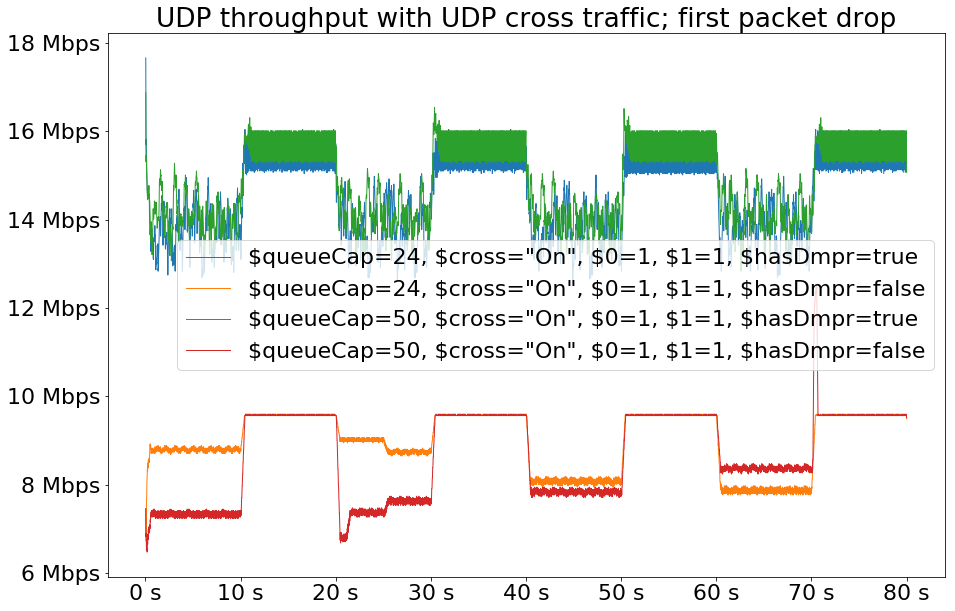

In [25]:
# Trying to plot throughput until first drop, plot the first drop time (at least as a tick on X-axis)

final_version = False
save_figure = False

plt.rcParams["figure.figsize"] =(15,10)
plt.rcParams.update({'font.size': 22})
formatter_x = EngFormatter(unit='s')
formatter_y = EngFormatter(unit='bps')

# max_min = vectors_arranged.drop_min_vectime.max()
max_min = 0
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter_x)
# ax.set_yscale('log')
ax.yaxis.set_major_formatter(formatter_y)
if(not final_version):
    ax.set_title("UDP throughput with UDP cross traffic; first packet drop")
legend = list()
print(vectors_arranged[(vectors_arranged.queueCap > 1) &  (vectors_arranged.cross == "\"On\"")].columns)
for row in vectors_arranged[(vectors_arranged.queueCap > 1) &  (vectors_arranged.cross == "\"On\"")].itertuples():
#     print(row)

    print(row)
    #For hexagon topology (fewer ethernet interfaces)
    #For Fulltest topology -> hexagon + 4 (2 interfaces *(vectime, vecvalue))
    itervar = row[1]
    print(itervar)
#     drop_min_vectime = row[9]
#     drop_min_vectime = pd.to_timedelta(row[7], unit='s')
#     drop_min_vectime.date
    
    appThroughputValue = row[3]
    appThroughputIndex = row[2]
    hasDmpr = row[34]
    
#     max_min = max(max_min, drop_min_vectime)
    if(final_version):
        if(hasDmpr):
            legend.append("With mechanism")
        else:
            legend.append("Without mechanism")
    else: 
        legend.append(itervar)
        
    

    #     print(pd.to_timedelta(row.vectime,  unit='s'))
    print_series = pd.Series(appThroughputValue, index = pd.to_timedelta(appThroughputIndex,  unit='s'))
#     print_series = trimTimeDeltaSeries(print_series, after=pd.to_timedelta(drop_min_vectime, unit='s'))
    result = print_series.resample('10ms',label='right').sum()*8*100
    resultPlot = result.rolling( window=40, min_periods=3).mean()

#     resultPlot = print_series.cumsum()
#     resultPlot = trimTimeDeltaSeries(resultPlot, after=pd.to_timedelta(drop_min_vectime, unit='s'))
    
    
    #get closest index from resultPlot
#     idx = resultPlot.index.get_loc(pd.to_timedelta(drop_min_vectime, unit='s'), 'nearest')

#     meanLine = result.rolling(window=result.size, min_periods=10).mean()
    start = print_series.index.min()
    end = print_series.index.max()
    avg_speed = 100*8*1000*1000/(end.total_seconds()-20.0)

#     print(meanLine)
    plt.plot(resultPlot.index.total_seconds() - 20, resultPlot.values,  linewidth=1,) #
#     plt.plot(meanLine.index.total_seconds(), meanLine.values, color='red')
#     plt.plot(resultPlot.index.total_seconds(), np.ndarray((resultPlot.size), dtype=meanPoint))
#     dropArray = np.concatenate((row[7], row[8], row[9], row[10]))



#     ax.scatter(dropArray, np.ones(shape=(dropArray.size, )))
#     ax.scatter(dropArray, resultPlot[resultPlot.index.get_loc(key=dropArray,method="nearest")], color="green")
    # vertical dotted line originating at mean value
    
    
#     #average line
#     meanPoint = resultPlot.mean()
#     meanPoint_text = formatter_y(avg_speed)
#     legend.append(itervar + "; avg=" + meanPoint_text)
#     plt.axhline(meanPoint, linestyle='dashed', linewidth=0.7)
    
# #     print(row.iterationvars)
    
#     fig.savefig("fig/single_conn/Full_SingleConn_"+row[12] + ".png", bbox_inches='tight') 



# plt.xlim(left= 0.0,right=max_min + 0.11 - 20)
ax.legend(legend)
plt.show()
if(save_figure):
    if(final_version):
        fig.savefig("fig/single_conn/Hex_UdpEcn.png", bbox_inches='tight') 
    else:
        ax.legend(legend)
        fig.savefig("fig/single_conn/Backup_UdpEcn.png", bbox_inches='tight')

In [26]:
vectors_arranged


module_name                                        Hexagon.client499.app[0].rcvdPk:vector(packetBytes)  \
                                                                                         iterationvars   
run                                                                                                      
HexSingleConnUdpRedUdpCross-0-20190124-15:58:48...  $queueCap=24, $cross="On", $0=1, $1=1, $hasDmp...    
HexSingleConnUdpRedUdpCross-1-20190124-15:58:48...  $queueCap=24, $cross="On", $0=1, $1=1, $hasDmp...    
HexSingleConnUdpRedUdpCross-2-20190124-15:58:48...  $queueCap=24, $cross="Off", $0=default, $1=def...    
HexSingleConnUdpRedUdpCross-3-20190124-15:58:48...  $queueCap=24, $cross="Off", $0=default, $1=def...    
HexSingleConnUdpRedUdpCross-4-20190124-15:58:48...  $queueCap=50, $cross="On", $0=1, $1=1, $hasDmp...    
HexSingleConnUdpRedUdpCross-5-20190124-15:58:48...  $queueCap=50, $cross="On", $0=1, $1=1, $hasDmp...    
HexSingleConnUdpRedUdpCross-6-20190124-15:58:48...  $queueCap=50, $cross="Off", $0=default, $1=def...    
HexSingleConnUdpRedUdpCross-7-20190124-15:58:48...  $queueCap=50, $cross="Off", $0=default, $1=def...    

module_name                                                                                            \
                                                                                              vectime   
run                                                                                                     
HexSingleConnUdpRedUdpCross-0-20190124-15:58:48...  [20.0206672, 20.02079024, 20.02091328, 20.0210...   
HexSingleConnUdpRedUdpCross-1-20190124-15:58:48...  [20.0227824, 20.02290544, 20.02302848, 20.0249...   
HexSingleConnUdpRedUdpCross-2-20190124-15:58:48...  [20.0191968, 20.01931984, 20.01944288, 20.0195...   
HexSingleConnUdpRedUdpCross-3-20190124-15:58:48...  [20.0191968, 20.01931984, 20.01944288, 20.0195...   
HexSingleConnUdpRedUdpCross-4-20190124-15:58:48...  [20.01931984, 20.01944288, 20.01956592, 20.019...   
HexSingleConnUdpRedUdpCross-5-20190124-15:58:48...  [20.0218976, 20.02202064, 20.02214368, 20.0240...   
HexSingleConnUdpRedUdpCross-6-20190124-15:58:48...  [20.0191968, 20.01931984, 20.01944288, 20.0195...   
HexSingleConnUdpRedUdpCross-7-20190124-15:58:48...  [20.0191968, 20.01931984, 20.01944288, 20.0195...   

module_name                                                                                            \
                                                                                             vecvalue   
run                                                                                                     
HexSingleConnUdpRedUdpCross-0-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....   
HexSingleConnUdpRedUdpCross-1-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....   
HexSingleConnUdpRedUdpCross-2-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....   
HexSingleConnUdpRedUdpCross-3-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....   
HexSingleConnUdpRedUdpCross-4-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....   
HexSingleConnUdpRedUdpCross-5-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....   
HexSingleConnUdpRedUdpCross-6-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....   
HexSingleConnUdpRedUdpCross-7-20190124-15:58:48...  [1472.0, 1472.0, 1472.0, 1472.0, 1472.0, 1472....   

module_name                                          Hexagon.routerCore1.dmpr.congLevel.eth[1]:vector  \
                                                                                        iterationvars   
run                                                                                                     
HexSingleConnUdpRedUdpCross-0-20190124-15:58:48...  $queueCap=24, $cross="On", $0=1, $1=1, $hasDmp...   
HexSingleConnUdpRedUdpCross-1-20190124-15:58:48...                                                 []